In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn import metrics, preprocessing, model_selection,impute
from scipy.stats import skew

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv', 'sample_submission.csv', 'data_description.txt']


In [28]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")

In [29]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [30]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [31]:
X = train_df.drop(['SalePrice','Id'],axis=1)
y = train_df['SalePrice']

X_validate = test_df.drop('Id',axis=1)

print("X shape: {} X_validate shape: {}".format(X.shape, X_validate.shape))

X shape: (1460, 79) X_validate shape: (1459, 79)


In [32]:
combine_df = X.append(X_validate, ignore_index = True)

**Missing Values!**

In [33]:
missing_data = pd.DataFrame()
missing_data['count'] = combine_df.isnull().sum()
missing_data['% count'] = (missing_data['count']/ len(combine_df)) * 100
    
mask1 = missing_data['% count']>40
mask2 = missing_data['% count']>0
    
print("missing_data > 40%: \n",missing_data[mask1])
columns_to_drop = missing_data[mask1].index.tolist()
print("columns_to_drop: \n",columns_to_drop)
combine_df.drop(columns_to_drop, axis=1, inplace=True)

print("*"*30)   
print("\n 0% < missing_data < 40%: \n",missing_data[~mask1 & mask2])
columns_with_NaN =missing_data[~mask1 & mask2].index.tolist()
print("columns_with_NaN: \n",columns_with_NaN)

missing_data > 40%: 
              count    % count
Alley         2721  93.216855
FireplaceQu   1420  48.646797
PoolQC        2909  99.657417
Fence         2348  80.438506
MiscFeature   2814  96.402878
columns_to_drop: 
 ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
******************************

 0% < missing_data < 40%: 
               count    % count
MSZoning          4   0.137033
LotFrontage     486  16.649538
Utilities         2   0.068517
Exterior1st       1   0.034258
Exterior2nd       1   0.034258
MasVnrType       24   0.822199
MasVnrArea       23   0.787941
BsmtQual         81   2.774923
BsmtCond         82   2.809181
BsmtExposure     82   2.809181
BsmtFinType1     79   2.706406
BsmtFinSF1        1   0.034258
BsmtFinType2     80   2.740665
BsmtFinSF2        1   0.034258
BsmtUnfSF         1   0.034258
TotalBsmtSF       1   0.034258
Electrical        1   0.034258
BsmtFullBath      2   0.068517
BsmtHalfBath      2   0.068517
KitchenQual       1   0.034258
Functiona

In [34]:
num_columns_with_NaN = combine_df[columns_with_NaN]._get_numeric_data().columns.tolist()
print("\n Numerical columns: \n", num_columns_with_NaN)
cat_columns_with_NaN = list(set(columns_with_NaN) - set(num_columns_with_NaN))
print("\n Categorical columns: \n", cat_columns_with_NaN)


 Numerical columns: 
 ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']

 Categorical columns: 
 ['GarageCond', 'BsmtFinType2', 'MasVnrType', 'BsmtExposure', 'Functional', 'KitchenQual', 'BsmtFinType1', 'GarageQual', 'MSZoning', 'BsmtCond', 'GarageType', 'GarageFinish', 'SaleType', 'Utilities', 'BsmtQual', 'Exterior1st', 'Exterior2nd', 'Electrical']


In [35]:
combine_df['MSZoning'].unique()

array(['RL', 'RM', 'C (all)', 'FV', 'RH', nan], dtype=object)

In [36]:
cols_to_move = ['BsmtFullBath','BsmtHalfBath','GarageYrBlt','GarageCars']

for col in cols_to_move:
    num_columns_with_NaN.remove(col)
    cat_columns_with_NaN.append(col)

In [37]:
from sklearn.impute import SimpleImputer

# Fill missing values for 'num_columns_with_NaN'
combine_df['LotFrontage'] = combine_df.groupby('Neighborhood')['LotFrontage'].transform(lambda x:x.fillna(x.median()))

imp_zero = SimpleImputer(missing_values=np.nan, strategy='constant')
combine_df[['MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','GarageArea']] = \
                    imp_zero.fit_transform(combine_df[['MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','GarageArea']])

combine_df['TotalBsmtSF']  = combine_df['TotalBsmtSF'].fillna(combine_df['BsmtFinSF1'] \
                            + combine_df['BsmtFinSF2']+ combine_df['BsmtUnfSF'])

In [38]:
# Fill missing values for 'cat_columns_with_NaN'
imp_zero = SimpleImputer(missing_values=np.nan, strategy='constant')
combine_df[['BsmtFullBath','BsmtHalfBath','GarageYrBlt','GarageCars']] = \
                    imp_zero.fit_transform(combine_df[['BsmtFullBath','BsmtHalfBath','GarageYrBlt','GarageCars']])

imp_none = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='None')
combine_df[['KitchenQual','MasVnrType','Functional','Electrical','Utilities']] = \
                    imp_none.fit_transform(combine_df[['KitchenQual','MasVnrType','Functional','Electrical','Utilities']])

imp_other = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Other')
combine_df[['Exterior1st','Exterior2nd','MSZoning','SaleType']] = \
                    imp_other.fit_transform(combine_df[['Exterior1st','Exterior2nd','MSZoning','SaleType']])
combine_df['SaleType'] = combine_df['SaleType'].fillna('Oth')

imp_bsmt = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='No_Basement')
combine_df[['BsmtQual','BsmtCond','BsmtFinType1','BsmtFinType2','BsmtExposure']] = \
                    imp_bsmt.fit_transform(combine_df[['BsmtQual','BsmtCond','BsmtFinType1','BsmtFinType2','BsmtExposure']])

imp_garage = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='No_Garage')
combine_df[['GarageType','GarageCond','GarageFinish','GarageQual']] = \
                    imp_other.fit_transform(combine_df[['GarageType','GarageCond','GarageFinish','GarageQual']])

In [39]:
combine_df.isnull().sum().sum()

0

In [40]:
num_cols = combine_df._get_numeric_data().columns.tolist()
cat_cols = list(set(combine_df.columns) - set(num_cols))
print("num_cols: {} \n cat_cols: {}".format(num_cols, cat_cols))

num_cols: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'] 
 cat_cols: ['Condition2', 'Functional', 'CentralAir', 'MSZoning', 'Heating', 'GarageQual', 'ExterCond', 'Exterior2nd', 'Electrical', 'HeatingQC', 'BsmtFinType2', 'MasVnrType', 'KitchenQual', 'PavedDrive', 'RoofMatl', 'BsmtCond', 'GarageType', 'LotShape', 'SaleType', 'Neighborhood', 'HouseStyle', 'Condition1', 'BsmtFinType1', 'LandSlope', 'GarageFinish', 'Street', 'Exterior1st', 'LandContour', 'BsmtQual', 'GarageCond', 'BsmtExposure', 'SaleCondition', 'ExterQual', 'Foundation', 'RoofS

In [41]:
cols_to_move = ['OverallQual','OverallCond','YearBuilt', 'YearRemodAdd','BsmtFullBath', 'BsmtHalfBath',\
                'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',  \
                'GarageYrBlt', 'GarageCars','MoSold', 'YrSold']
for col in cols_to_move:
    num_cols.remove(col)
    cat_cols.append(col)

In [42]:
combine_df[num_cols].describe()

,MSSubClass,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,69.542994,10168.114080,101.396026,441.272011,49.565262,560.579993,1051.417266,1159.581706,336.483727,4.694416,1500.759849,472.712573,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968
std,42.517628,21.703256,7886.996359,178.854579,455.606014,169.179104,439.590889,441.120498,392.362079,428.701456,46.396825,506.051045,215.535686,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211
min,20.000000,21.000000,1300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,60.000000,7478.000000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,0.000000,0.000000,1126.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.000000,70.000000,9453.000000,0.000000,368.000000,0.000000,467.000000,989.000000,1082.000000,0.000000,0.000000,1444.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,70.000000,80.000000,11570.000000,163.500000,733.000000,0.000000,805.000000,1302.000000,1387.500000,704.000000,0.000000,1743.500000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,190.000000,313.000000,215245.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000


In [43]:
corr = combine_df[num_cols].corr()
corr

,MSSubClass,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
MSSubClass,1.000000,-0.400908,-0.201730,0.006309,-0.064002,-0.072431,-0.125561,-0.219008,-0.248641,0.309309,0.026482,0.071677,-0.103534,-0.017654,-0.015923,-0.020867,-0.037529,-0.049181,-0.003080,-0.028867
LotFrontage,-0.400908,1.000000,0.387612,0.219629,0.215706,0.056049,0.100304,0.344241,0.438699,0.027077,0.002888,0.363344,0.353053,0.119778,0.157999,0.006767,0.029015,0.073681,0.155863,0.038065
LotArea,-0.201730,0.387612,1.000000,0.124728,0.194168,0.084107,0.021590,0.254316,0.332460,0.031515,0.000554,0.284519,0.213180,0.158045,0.104797,0.020974,0.015995,0.054375,0.093708,0.069029
MasVnrArea,0.006309,0.219629,0.124728,1.000000,0.301537,-0.014580,0.088173,0.393715,0.392367,0.119377,-0.057380,0.400088,0.371071,0.166606,0.140880,-0.110614,0.014059,0.066392,0.004791,0.045156
BsmtFinSF1,-0.064002,0.215706,0.194168,0.301537,1.000000,-0.054938,-0.476771,0.536650,0.458206,-0.161997,-0.065984,0.211980,0.310219,0.223681,0.124366,-0.099575,0.050934,0.096901,0.084470,0.093310
BsmtFinSF2,-0.072431,0.056049,0.084107,-0.014580,-0.054938,1.000000,-0.238043,0.089561,0.084389,-0.097654,-0.004913,-0.017747,0.003446,0.098462,-0.005805,0.032775,-0.023268,0.063329,0.044530,-0.005130
BsmtUnfSF,-0.125561,0.100304,0.021590,0.088173,-0.476771,-0.238043,1.000000,0.412810,0.296788,-0.000032,0.046944,0.234388,0.165014,-0.038964,0.120027,0.005162,-0.005764,-0.049019,-0.032236,-0.010450
TotalBsmtSF,-0.219008,0.344241,0.254316,0.393715,0.536650,0.089561,0.412810,1.000000,0.801376,-0.204802,-0.023253,0.445710,0.486169,0.229960,0.245835,-0.085131,0.037940,0.075522,0.072197,0.083993
1stFlrSF,-0.248641,0.438699,0.332460,0.392367,0.458206,0.084389,0.296788,0.801376,1.000000,-0.249823,-0.012704,0.562538,0.491996,0.227347,0.238502,-0.065796,0.044086,0.098381,0.121900,0.093062
2ndFlrSF,0.309309,0.027077,0.031515,0.119377,-0.161997,-0.097654,-0.000032,-0.204802,-0.249823,1.000000,0.017803,0.655085,0.127464,0.089922,0.185387,0.054645,-0.032458,0.011070,0.044503,-0.005299


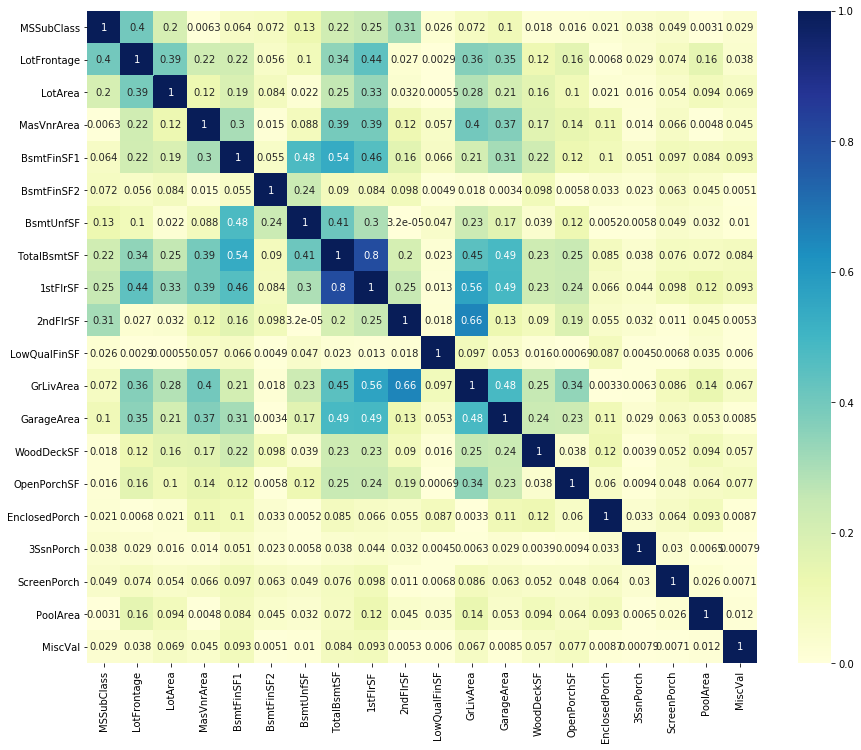

In [44]:
corr = combine_df[num_cols].corr()
f, ax = plt.subplots(figsize = (15,12))
sns.heatmap(abs(corr), annot=True, cmap="YlGnBu")

In [45]:
threshold = 0.5
corr_var_list = []

for i in range(1, len(num_cols)):
    for j in range(i):
        if((abs(corr.iloc[i,j]) > threshold) & (abs(corr.iloc[i,j]) < 1)):
            corr_var_list.append([corr.iloc[i,j], i, j])

# Sort the list showing higher ones first 
s_corr_list = sorted(corr_var_list ,key = lambda x:abs(x[0]))

#Print correlations and column names
for corr_value, i, j in s_corr_list:
    print ("%s , %s = %.2f" % (num_cols[i],num_cols[j],corr_value))

TotalBsmtSF , BsmtFinSF1 = 0.54
GrLivArea , 1stFlrSF = 0.56
GrLivArea , 2ndFlrSF = 0.66
1stFlrSF , TotalBsmtSF = 0.80


In [46]:
combine_df.drop(['1stFlrSF','2ndFlrSF','BsmtFinSF1'], axis=1, inplace=True)

for col in ['1stFlrSF','2ndFlrSF','BsmtFinSF1']:
    num_cols.remove(col)

In [47]:
combine_df = pd.get_dummies(combine_df)
combine_df.shape

(2919, 283)

In [48]:
skewness = pd.DataFrame(data={'name':num_cols,'skewness':skew(combine_df[num_cols])})

highly_skewed_cols = skewness[abs(skewness['skewness'])>=1]['name']

for col in highly_skewed_cols:
    combine_df[col] = np.log1p(combine_df[col])

In [49]:
robust_scaler = preprocessing.RobustScaler()
for col in num_cols:
    combine_df[col] = robust_scaler.fit_transform(combine_df[[col]])

In [50]:
X = combine_df.iloc[:1460,:]
X_validate = combine_df.iloc[1460:,:]
print("X shape: {}, X_validate shape: {}".format(X.shape,X_validate.shape))

X shape: (1460, 283), X_validate shape: (1459, 283)


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

NameError: name 'train_test_split' is not defined

In [ ]:
sns.distplot(y)